<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/Dacon_%EC%8B%A0%EC%9A%A9_%EC%98%88%EC%B8%A1_%EB%B3%B5%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures

In [6]:
train = pd.read_csv('/content/drive/MyDrive/dataset/Dacon/대회/신용카드 사용자 연체 예측 AI 경진대회/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/Dacon/대회/신용카드 사용자 연체 예측 AI 경진대회/test.csv')
print(f'train shape:{train.shape}')
print(f'test shape:{test.shape}')
test_index = test['index']

train shape:(26457, 20)
test shape:(10000, 19)


In [7]:
data = pd.concat([train, test], axis=0).reset_index(drop=True)

In [4]:
data['identity'] = [str(data[['gender',	'car',	'reality',	'child_num',	'income_total',	'income_type',	'edu_type',	'family_type',	'house_type',	'DAYS_BIRTH',	'DAYS_EMPLOYED',	'FLAG_MOBIL',	'work_phone',	'phone',	'email',	'occyp_type',	'family_size']].loc[i].values) for i in data.index]

KeyboardInterrupt: ignored

In [ ]:
all_labels = data.groupby('identity')['credit'].nunique() != 1
err_labels = all_labels[all_labels != False]

In [ ]:
print('에러 중복인물 의심 인원 숫자:',err_labels.shape[0])
data[data['identity'] == err_labels.index[1]] # 중복의심 예 고민...

에러 중복인물 의심 인원 숫자: 3807


,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,identity
11033,11033,F,N,N,0,103500.0,Working,Higher education,Married,House / apartment,-15989,-6640,1,1,1,0,NaN,2.0,-15.0,2.0,['F' 'N' 'N' 0 103500.0 'Working' 'Higher educ...
20137,20137,F,N,N,0,103500.0,Working,Higher education,Married,House / apartment,-15989,-6640,1,1,1,0,NaN,2.0,-3.0,0.0,['F' 'N' 'N' 0 103500.0 'Working' 'Higher educ...
21166,21166,F,N,N,0,103500.0,Working,Higher education,Married,House / apartment,-15989,-6640,1,1,1,0,NaN,2.0,-5.0,1.0,['F' 'N' 'N' 0 103500.0 'Working' 'Higher educ...
27357,27357,F,N,N,0,103500.0,Working,Higher education,Married,House / apartment,-15989,-6640,1,1,1,0,NaN,2.0,-16.0,NaN,['F' 'N' 'N' 0 103500.0 'Working' 'Higher educ...
34077,34077,F,N,N,0,103500.0,Working,Higher education,Married,House / apartment,-15989,-6640,1,1,1,0,NaN,2.0,-3.0,NaN,['F' 'N' 'N' 0 103500.0 'Working' 'Higher educ...


In [22]:
data

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,begin_years,DAYS_EMPLOYED_ANOM,age,employed,working_ratio,daily_wage,property,age_cut,employed_cut,daily_wage_cut
0,0,0,0,0,0,202500.0,0,1,1,2,-13899,-4709.0,1,0,0,0,NaN,2.0,-6.0,1.0,0.500000,False,38.079452,12.901370,33.880135,43.002761,1,35-40,10-20,0-1600
1,1,0,0,1,1,247500.0,0,4,0,1,-11380,-1540.0,1,0,0,1,Laborers,3.0,-5.0,1.0,0.416667,False,31.178082,4.219178,13.532513,160.714286,2,30-35,0-10,0-1600
2,2,1,1,1,0,450000.0,4,1,1,1,-19087,-4434.0,1,0,1,0,Managers,2.0,-22.0,2.0,1.833333,False,52.293151,12.147945,23.230471,101.488498,4,51-58,10-20,0-1600
3,3,0,0,1,0,202500.0,0,4,1,1,-15088,-2092.0,1,0,1,0,Sales staff,2.0,-37.0,0.0,3.083333,False,41.336986,5.731507,13.865323,96.797323,3,40-45,0-10,0-1600
4,4,0,1,1,0,157500.0,2,1,1,1,-15037,-2105.0,1,0,0,0,Managers,2.0,-26.0,2.0,2.166667,False,41.197260,5.767123,13.998803,74.821853,3,40-45,0-10,0-1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,36452,0,1,1,0,202500.0,4,2,1,1,-18593,-5434.0,1,1,1,0,Accountants,2.0,-19.0,NaN,1.583333,False,50.939726,14.887671,29.226053,37.265366,5,45-51,10-20,0-1600
36453,36453,1,1,1,0,202500.0,4,4,0,1,-10886,-1315.0,1,1,0,0,Laborers,2.0,-34.0,NaN,2.833333,False,29.824658,3.602740,12.079735,153.992395,4,20-30,0-10,0-1600
36454,36454,0,0,1,0,292500.0,4,4,1,1,-21016,-14018.0,1,0,0,0,Medicine staff,2.0,-55.0,NaN,4.583333,False,57.578082,38.405479,66.701561,20.866029,2,51-58,30-40,0-1600
36455,36455,0,1,0,0,180000.0,0,4,1,1,-16541,-1085.0,1,0,1,0,NaN,2.0,-33.0,NaN,2.750000,False,45.317808,2.972603,6.559458,165.898618,3,40-45,0-10,0-1600


In [10]:
from sklearn.preprocessing import LabelEncoder

In [12]:
encoders = LabelEncoder()

for i in data.select_dtypes('object'):
  if i == 'occyp_type':
    continue
  else:
    data[i] = encoders.fit_transform(data[i])

In [ ]:
encoders = LabelEncoder()

for i in data.select_dtypes('object'):
  if data[i].nunique() <= 2:
    data[i] = encoders.fit_transform(data[i])
  elif i == 'occyp_type':
    continue
  else:
    data = pd.get_dummies(data=data, columns=[i])

# occyp_type만 남기고 다 인코딩

In [13]:
corr_matrix = data.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [c for c in upper.columns if any(abs(upper[c])>0.9)]
to_drop
# 제거할 Feature는 안보인다.

[]

In [ ]:
def plot_categoricals(x, y, data, annotate = True):
    """Plot counts of two categoricals.
    Size is raw count for each grouping.
    Percentages are for a given value of y."""
    
    # Raw counts 
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = False))
    raw_counts = raw_counts.rename(columns = {x: 'raw_count'})
    
    # Calculate counts for each group of x and y
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    
    # Rename the column and reset the index
    counts = counts.rename(columns = {x: 'normalized_count'}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']
    
    # Add the raw count
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize = (14, 10))
    # Scatter plot sized by percent
    plt.scatter(counts[x], counts[y], edgecolor = 'k', color = 'lightgreen',
                s = 100 * np.sqrt(counts['raw_count']), marker = 'o',
                alpha = 0.6, linewidth = 1.5)
    
    if annotate:
        # Annotate the plot with text
        for i, row in counts.iterrows():
            # Put text with appropriate offsets
            plt.annotate(xy = (row[x] - (1 / counts[x].nunique()), 
                               row[y] - (0.15 / counts[y].nunique())),
                         color = 'navy',
                         s = f"{round(row['percent'], 1)}%")
        
    # Set tick marks
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())
    
    # Transform min and max to evenly space in square root domain
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
    
    # 5 sizes for legend
    msizes = list(range(sqr_min, sqr_max,
                        int(( sqr_max - sqr_min) / 5)))
    markers = []
    
    # Markers for legend
    for size in msizes:
        markers.append(plt.scatter([], [], s = 100 * size, 
                                   label = f'{int(round(np.square(size) / 100) * 100)}', 
                                   color = 'lightgreen',
                                   alpha = 0.6, edgecolor = 'k', linewidth = 1.5))
        
    # Legend and formatting
    plt.legend(handles = markers, title = 'Counts',
               labelspacing = 3, handletextpad = 2,
               fontsize = 16,
               loc = (1.10, 0.19))
    
    plt.annotate(f'* Size represents raw count while % is for a given y value.',
                 xy = (0, 1), xycoords = 'figure points', size = 10)
    
    # Adjust axes limits
    plt.xlim((counts[x].min() - (6 / counts[x].nunique()), 
              counts[x].max() + (6 / counts[x].nunique())))
    plt.ylim((counts[y].min() - (4 / counts[y].nunique()), 
              counts[y].max() + (4 / counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f"{x}"); plt.ylabel(f"{y}"); plt.title(f"{y} vs {x}");

# Feature Engineering

In [ ]:
data['begin_month'] = abs(data['begin_month'])
data['DAYS_EMPLOYED'] = abs(data['DAYS_EMPLOYED'])
data['DAYS_BIRTH'] = abs(data['DAYS_BIRTH'])

In [14]:
data['begin_years'] = data['begin_month'] / -12

In [15]:
data['DAYS_EMPLOYED_ANOM'] = data['DAYS_EMPLOYED'] == 365243
data.loc[data['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED'] = np.NaN

In [16]:
data['age'] = data['DAYS_BIRTH'] / -365
data['employed'] = data['DAYS_EMPLOYED'] / -365

In [17]:
data['working_ratio'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH'] * 100
data['daily_wage'] = data['income_total'] / -data['DAYS_EMPLOYED']

In [18]:
data['property'] = data['car'] + data['reality'] + data['phone'] + data['FLAG_MOBIL'] + data['work_phone']

In [19]:
labels = ['20-30', '30-35', '35-40', '40-45', '45-51', '51-58', '58-']
data['age_cut'] = pd.qcut(data['age'], 7, labels=labels)

In [20]:
labels = ['0-10', '10-20', '20-30', '30-40', '40-50']
data['employed_cut'] = pd.cut(data['employed'], bins=np.linspace(0,50, num=6), labels=labels)

In [21]:
labels = ['0-1600', '1600-3200', '3200-4800', '4800-6400', '6400-8000']
data['daily_wage_cut'] = pd.cut(data['daily_wage'], bins=np.linspace(0,8000, num=6), labels=labels)

In [ ]:
data.isnull().sum()

index                     0
gender                    0
car                       0
reality                   0
child_num                 0
income_total              0
income_type               0
edu_type                  0
family_type               0
house_type                0
DAYS_BIRTH                0
DAYS_EMPLOYED          6135
FLAG_MOBIL                0
work_phone                0
phone                     0
email                     0
occyp_type            11323
family_size               0
begin_month               0
credit                10000
begin_years               0
DAYS_EMPLOYED_ANOM        0
age                       0
employed               6135
working_ratio          6135
daily_wage             6135
property                  0
age_cut                   0
employed_cut           6135
daily_wage_cut         6135
dtype: int64

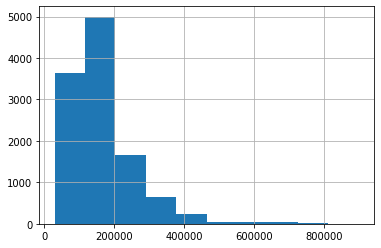

In [ ]:
data[data['occyp_type'].isnull()]['income_total'].hist()
# 어느 특정 직업의 정상적인 분포같음

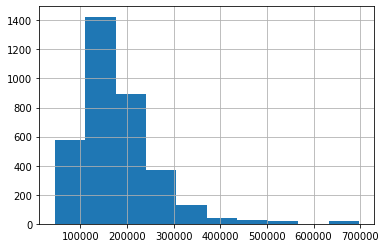

In [ ]:
data[data['occyp_type'] == 'Sales staff']['income_total'].hist()
# Nan값의 연봉에 비하여 분포 차이가 그렇게 많이 나지도 않는다.

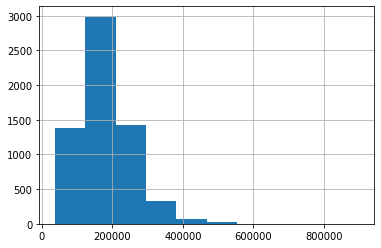

In [ ]:
data[data['occyp_type'] == 'Laborers']['income_total'].hist()

In [23]:
for col in ['child_num', 'family_size']:
    data[col] = np.log2(1 + data[col])
    
data['DAYS_BIRTH'] = np.log2(1 - data['DAYS_BIRTH'])
data['DAYS_EMPLOYED'] = np.log(1 - data['DAYS_EMPLOYED'])
data['income_total'] = np.log2(1+data['income_total'])

In [ ]:
# income_total, age, employed를 카테고리 화 Feature Engineering

In [24]:
data['occyp_type'] = data['occyp_type'].fillna('etc')

In [25]:
data = pd.get_dummies(data=data, columns=['occyp_type', 'age_cut', 'employed_cut',	'daily_wage_cut'])

In [ ]:
# aggregation은 다음에 시도해보자...

In [26]:
def missing_data(data):
  total = data.isnull().sum()
  percent = round(data.isnull().sum()/len(data)*100, 2)

  table = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).sort_values('Percent', ascending=False)
  table = table[table['Total'] != 0]
  return table

In [35]:
missing_data(data)

,Total,Percent
credit,10000,27.43
working_ratio,6135,16.83
employed,6135,16.83
daily_wage,6135,16.83


In [28]:
data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].fillna(data['DAYS_EMPLOYED'].median())

In [29]:
feature_data = data.columns

In [ ]:
data_poly = data[['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'family_size', 'begin_month']]
polynomial = PolynomialFeatures(degree=3)

polynomial.fit(data_poly)
data_poly = polynomial.transform(data_poly)

In [ ]:
data_poly = pd.DataFrame(data_poly, columns = polynomial.get_feature_names(input_features=['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'family_size', 'begin_month'])).drop(columns='1')

In [ ]:
data_ids = data['index']
data_ids = data_ids.reset_index(drop=True)
data_poly = data_poly.reset_index(drop=True)
data_poly = pd.concat([data_ids, data_poly], axis=1)

In [ ]:
data = data.merge(data_poly, how='left', on='index')
data.shape

(36457, 117)

In [30]:
data_agg = data.drop(columns=['credit']).groupby('index').agg(['sum', 'min', 'max', 'count', 'median'])
data_col = []
for i in data_agg.columns.levels[0]:
  for j in data_agg.columns.levels[1]:
    data_col.append(f'{i}-{j}')

data_agg.columns = data_col

In [31]:
corr_matrix = data_agg.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [c for c in upper.columns if any(abs(upper[c])>0.95)]
print(f'whole:{len(data_agg.columns)},drop:{len(to_drop)}')

whole:300,drop:184


In [32]:
data_agg = data_agg.drop(columns=to_drop)

In [33]:
data = data.merge(data_agg, how='left', on='index')

In [34]:
data.shape

(36457, 178)

In [36]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, plot_confusion_matrix, classification_report, make_scorer, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, robust_scale
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm


scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

In [81]:
x_train = data[data['credit'].notnull()].drop(columns=['credit', 'index'])
y_train = data[data['credit'].notnull()]['credit']
x_test = data[data['credit'].isnull()].drop(columns=['credit', 'index'])
train_columns = x_train.columns
print(x_train.shape, x_test.shape)

(26457, 176) (10000, 176)


In [83]:
x_train, x_test = x_train.align(x_test, join='inner', axis=1)
features = x_train.columns

In [85]:
pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),('scaler', MinMaxScaler())])

x_train = pipeline.fit_transform(x_train)
x_test = pipeline.fit_transform(x_test)

In [50]:
x_train = robust_scale(x_train)
x_test = robust_scale(x_test)

In [60]:
x_train = pd.DataFrame(x_train, columns=features)
x_test = pd.DataFrame(x_test, columns=features)

In [ ]:
def macro_f1_score(labels, predictions):
    # Reshape the predictions as needed
    predictions = predictions.reshape(len(np.unique(labels)), -1 ).argmax(axis = 0)
    
    metric_value = f1_score(labels, predictions, average = 'macro')
    
    # Return is name, value, is_higher_better
    return 'macro_f1', metric_value, True

In [61]:
skf = StratifiedKFold(n_splits=5)
lgb_models = {}
for i, (train_indice, valid_indice) in enumerate(skf.split(X=x_train, y=y_train)):
  model = lgbm.LGBMClassifier(n_estimators=1000, n_jobs=-1, objective='Multiclass', metric='multi_logloss')
  X_train, X_valid = x_train.iloc[train_indice], x_train.iloc[valid_indice]
  Y_train, Y_valid = y_train.iloc[train_indice], y_train.iloc[valid_indice]

  model.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
            verbose=200, early_stopping_rounds=100)
  
  lgb_models[i] = model

Training until validation scores don't improve for 100 rounds.
[200]	training's multi_logloss: 0.587996	valid_1's multi_logloss: 0.735463
[400]	training's multi_logloss: 0.482936	valid_1's multi_logloss: 0.72639
Early stopping, best iteration is:
[367]	training's multi_logloss: 0.497282	valid_1's multi_logloss: 0.726013
Training until validation scores don't improve for 100 rounds.
[200]	training's multi_logloss: 0.586115	valid_1's multi_logloss: 0.73627
[400]	training's multi_logloss: 0.482394	valid_1's multi_logloss: 0.725195
Early stopping, best iteration is:
[427]	training's multi_logloss: 0.470435	valid_1's multi_logloss: 0.724831
Training until validation scores don't improve for 100 rounds.
[200]	training's multi_logloss: 0.587384	valid_1's multi_logloss: 0.736955
[400]	training's multi_logloss: 0.482123	valid_1's multi_logloss: 0.729279
Early stopping, best iteration is:
[370]	training's multi_logloss: 0.494971	valid_1's multi_logloss: 0.728301
Training until validation scores 

# nn사용

In [62]:
from sklearn.model_selection import StratifiedKFold
import random
from datetime import datetime

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm import tqdm

In [111]:
train_y_t = torch.tensor(y_train, dtype=torch.float32)
train_x_t = torch.tensor(x_train, dtype=torch.float32)
test_x_t = torch.tensor(x_test, dtype=torch.float32)
train_y_t = train_y_t.type(torch.LongTensor)

test_len = len(test_x_t)

In [119]:
N_REPEAT = 5
N_SKFOLD = 7
N_EPOCH = 48
BATCH_SIZE = 72
LOADER_PARAM = {
    'batch_size': BATCH_SIZE,
    'num_workers': 4,
    'pin_memory': True
}

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
prediction = np.zeros((test_len, 1), dtype=np.float32)
y_pred_list = []
for repeat in range(N_REPEAT):

    skf, tot = StratifiedKFold(n_splits=N_SKFOLD, random_state=repeat, shuffle=True), 0.
    for skfold, (train_idx, valid_idx) in enumerate(skf.split(x_train, y_train)):
        train_idx, valid_idx = list(train_idx), list(valid_idx)
        train_loader = DataLoader(TensorDataset(train_x_t[train_idx, :], train_y_t[train_idx]),
                                  shuffle=True, drop_last=True, **LOADER_PARAM)
        valid_loader = DataLoader(TensorDataset(train_x_t[valid_idx, :], train_y_t[valid_idx]),
                                  shuffle=False, drop_last=False, **LOADER_PARAM)
        test_loader = DataLoader(TensorDataset(test_x_t, torch.zeros((test_len,), dtype=torch.float32)),
                                 shuffle=False, drop_last=False, **LOADER_PARAM)
        model = nn.Sequential(
            nn.Dropout(0.05),
            nn.Linear(176, 400, bias=False),
            nn.LeakyReLU(0.05, inplace=True),
            nn.Dropout(0.5),
            nn.Linear(400, 222, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(222, 3)
        ).to(DEVICE)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=5e-3, weight_decay=7.8e-2)
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=N_EPOCH // 6, eta_min=4e-4)
        prediction_t, loss_t = np.zeros((test_len, 1), dtype=np.float32), 1.

        # for epoch in range(N_EPOCH):
        for epoch in tqdm(range(N_EPOCH), desc='{:02d}/{:02d}'.format(skfold + 1, N_SKFOLD)):
            model.train()
            for idx, (xx, yy) in enumerate(train_loader):
                optimizer.zero_grad() ## 최적화 준비
                xx, yy = xx.to(DEVICE), yy.to(DEVICE)
                pred = model(xx).squeeze() ## predict뽑아내기
                loss = criterion(pred, yy) ## loss 뽑아내기
                loss.backward()
                optimizer.step() ## 최적화로 뒤로간다
                scheduler.step(epoch + idx / len(train_loader))

            with torch.no_grad():
              model.eval()
              for X_batch, _ in test_loader:
                X_batch = X_batch.to(DEVICE)
                y_test_pred = model(X_batch)
                _, y_pred_tags = torch.max(y_test_pred, dim = 1)
                y_pred_list.append(y_pred_tags.cpu().numpy())
        y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

    

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))












01/07:   0%|          | 0/48 [00:00<?, ?it/s]











01/07:   2%|▏         | 1/48 [00:02<02:06,  2.69s/it]











01/07:   4%|▍         | 2/48 [00:05<02:02,  2.67s/it]











01/07:   6%|▋         | 3/48 [00:08<02:01,  2.69s/it]











01/07:   8%|▊         | 4/48 [00:10<01:59,  2.72s/it]











01/07:  10%|█         | 5/48 [00:13<01:56,  2.72s/it]











01/07:  12%|█▎        | 6/48 [00:16<01:53,  2.71s/it]











01/07:  15%|█▍        | 7/48 [00:18<01:51,  2.72s/it]











01/07:  17%|█▋      

KeyboardInterrupt: ignored

# feature selectoin

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(n_estimators=100, n_jobs=-1)

selector = RFECV(estimator, step=1, cv=3, scoring=scorer, n_jobs=-1)

In [ ]:
selector.fit(train_set, train_labels)

KeyboardInterrupt: ignored

In [ ]:
test_ids = test['index']
submit = pd.read_csv('/content/drive/MyDrive/dataset/Dacon/대회/신용카드 사용자 연체 예측 AI 경진대회/sample_submission.csv')

In [ ]:
for fold in range(5):
    submit.iloc[:,1:] += lgb_models[fold].predict_proba(test_set)/5

In [ ]:
submit = submit.set_index('index')
submit

,0,1,2
index,,,
26457,0.087689,0.163394,0.748917
26458,0.103057,0.129613,0.767330
26459,0.032084,0.068989,0.898927
26460,0.086808,0.100014,0.813178
26461,0.100738,0.273258,0.626004
...,...,...,...
36452,0.122497,0.137544,0.739960
36453,0.110274,0.263286,0.626440
36454,0.020402,0.100626,0.878972


In [ ]:
submit.to_csv('/content/drive/MyDrive/dataset/Dacon/대회/신용카드 사용자 연체 예측 AI 경진대회/2021-05-14 submit2.csv')